<a href="https://colab.research.google.com/github/cabb1808/ProyectoSenales3/blob/main/Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import scipy as sp


In [ ]:
!wget 'https://raw.githubusercontent.com/cabb1808/ProyectoSenales3/main/TRM.csv' -O 'TRM.csv'

--2023-06-07 04:41:24--  https://raw.githubusercontent.com/cabb1808/ProyectoSenales3/main/TRM.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220043 (215K) [text/plain]
Saving to: ‘TRM.csv’

TRM.csv             100%[===================>] 214.89K  --.-KB/s    in 0.02s   

2023-06-07 04:41:24 (12.6 MB/s) - ‘TRM.csv’ saved [220043/220043]



In [ ]:
#Importamos la database y ordenamos en orden cronologico ya que no lo está

data = pd.read_csv('TRM.csv')
# Convertir la columna de fechas al formato de fecha adecuado
data['VIGENCIADESDE'] = pd.to_datetime(data['VIGENCIADESDE'], format='%d/%m/%Y')

# Ordenar los datos por fecha
data.sort_values(by='VIGENCIADESDE', inplace=True)
datos = data[['VIGENCIADESDE', 'VALOR']]

datos['VIGENCIADESDE'] = pd.to_datetime(datos['VIGENCIADESDE'])
datos = datos.set_index('VIGENCIADESDE')

d = datos.resample('D').asfreq()


d['VALOR'].fillna(method='ffill', inplace=True)

print(d)

                 VALOR
VIGENCIADESDE         
1991-12-02      643.42
1991-12-03      639.22
1991-12-04      635.70
1991-12-05      631.51
1991-12-06      627.16
...                ...
2022-07-16     4395.63
2022-07-17     4395.63
2022-07-18     4395.63
2022-07-19     4315.41
2022-07-20     4303.34

[11189 rows x 1 columns]


<ipython-input-152-08c0800670b4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos['VIGENCIADESDE'] = pd.to_datetime(datos['VIGENCIADESDE'])


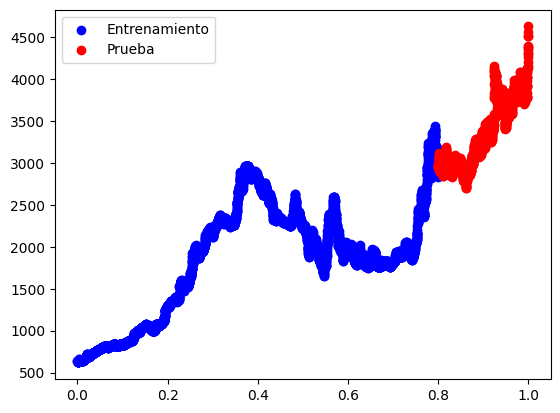

In [ ]:
#Creamos un vector temporal y separamos los datos en train y test

x = np.linspace(0, 1, len(datos))
y = datos["VALOR"].values
#x = np.arange(0, 11189/1000, 0.001)

idx = np.arange(len(x))
perTrain = 0.8
x_train = x[:int(len(idx)*perTrain)]
y_train = y[:int(len(idx)*perTrain)]

x_test = x[int(len(idx)*perTrain):]
y_test = y[int(len(idx)*perTrain):]


plt.scatter(x_train, y_train, color='blue', label='Entrenamiento')
plt.scatter(x_test, y_test, color='red', label='Prueba')
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.legend()

DatetimeIndex(['1991-12-02', '1991-12-03', '1991-12-04', '1991-12-05',
               '1991-12-06', '1991-12-07', '1991-12-08', '1991-12-09',
               '1991-12-10', '1991-12-11',
               ...
               '2022-07-11', '2022-07-12', '2022-07-13', '2022-07-14',
               '2022-07-15', '2022-07-16', '2022-07-17', '2022-07-18',
               '2022-07-19', '2022-07-20'],
              dtype='datetime64[ns]', name='VIGENCIADESDE', length=11189, freq='D')
(10629,)


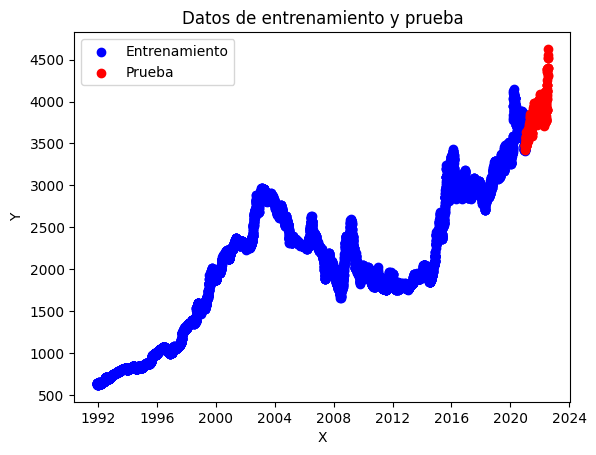

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

x = d.index
print(x)

X_train, X_test, y_train, y_test = train_test_split(x, d['VALOR'], test_size=0.05, shuffle=False)

print(X_train.shape)

plt.scatter(X_train, y_train, color='blue', label='Entrenamiento')
plt.scatter(X_test, y_test, color='red', label='Prueba')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Datos de entrenamiento y prueba')
plt.legend()
plt.show()



In [ ]:
from sklearn.linear_model import LinearRegression

# Create an instance of the LinearRegression model
model = LinearRegression()

# Train the model using the training data
model.fit(X_train.values.reshape(-1, 1), y_train)

# Make predictions on the test data

y_pred = model.predict(X_test.values.astype(int).reshape(-1, 1))


# Print the predictions
print("Predictions:", y_pred)

Predictions: [3160.01402455 3160.22034765 3160.42667075 3160.63299384 3160.83931694
 3161.04564004 3161.25196313 3161.45828623 3161.66460933 3161.87093243
 3162.07725552 3162.28357862 3162.48990172 3162.69622481 3162.90254791
 3163.10887101 3163.31519411 3163.5215172  3163.7278403  3163.9341634
 3164.14048649 3164.34680959 3164.55313269 3164.75945578 3164.96577888
 3165.17210198 3165.37842508 3165.58474817 3165.79107127 3165.99739437
 3166.20371746 3166.41004056 3166.61636366 3166.82268676 3167.02900985
 3167.23533295 3167.44165605 3167.64797914 3167.85430224 3168.06062534
 3168.26694844 3168.47327153 3168.67959463 3168.88591773 3169.09224082
 3169.29856392 3169.50488702 3169.71121011 3169.91753321 3170.12385631
 3170.33017941 3170.5365025  3170.7428256  3170.9491487  3171.15547179
 3171.36179489 3171.56811799 3171.77444109 3171.98076418 3172.18708728
 3172.39341038 3172.59973347 3172.80605657 3173.01237967 3173.21870277
 3173.42502586 3173.63134896 3173.83767206 3174.04399515 3174.250

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge

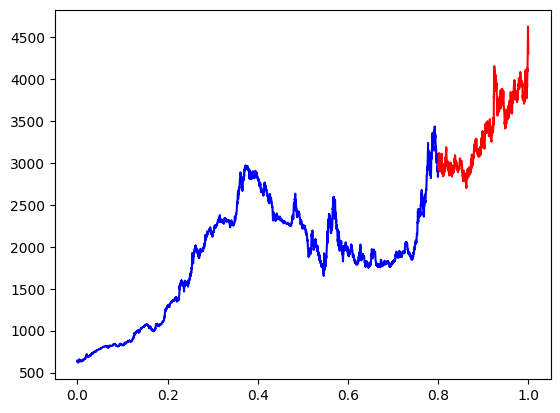

In [ ]:
#Creamos un vector temporal y separamos los datos en train y test

x = np.linspace(0, 1, len(datos))
y = datos["VALOR"].values


idx = np.arange(len(x))
perTrain = 0.8
x_train = x[:int(len(idx)*perTrain)]
y_train = y[:int(len(idx)*perTrain)]

x_test = x[int(len(idx)*perTrain):]
y_test = y[int(len(idx)*perTrain):]


plt.plot(x_train, y_train, color='blue', label='Entrenamiento')
plt.plot(x_test, y_test, color='red', label='Prueba')


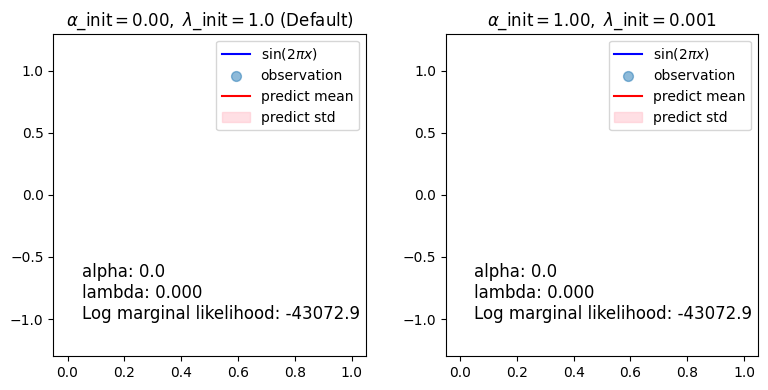

In [ ]:
from sklearn.linear_model import BayesianRidge

n_order = 3
X_train = np.vander(x_train, n_order + 1, increasing=True)
X_test = np.vander(x_test, n_order + 1, increasing=True)
reg = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for i, ax in enumerate(axes):
    # Bayesian ridge regression with different initial value pairs
    if i == 0:
        init = [1 / np.var(y_train), 1.0]  # Default values
    elif i == 1:
        init = [1.0, 1e-3]
        reg.set_params(alpha_init=init[0], lambda_init=init[1])
    reg.fit(X_train, y_train)
    ymean, ystd = reg.predict(X_test, return_std=True)

    ax.plot(x_test, y_test, color="blue", label="sin($2\\pi x$)")
    ax.scatter(x_train, y_train, s=50, alpha=0.5, label="observation")
    ax.plot(x_test, ymean, color="red", label="predict mean")
    ax.fill_between(
        x_test, ymean - ystd, ymean + ystd, color="pink", alpha=0.5, label="predict std"
    )
    ax.set_ylim(-1.3, 1.3)
    ax.legend()
    title = "$\\alpha$_init$={:.2f},\\ \\lambda$_init$={}$".format(init[0], init[1])
    if i == 0:
        title += " (Default)"
    ax.set_title(title, fontsize=12)
    text = "alpha: {:.1f}\nlambda: {:.3f}\nLog marginal likelihood: {:.1f}".format(
        reg.alpha_, reg.lambda_, reg.scores_[-1]
    )
    ax.text(0.05, -1.0, text, fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
def expo_carac(X, K):
    # Extraer caracteristicas exponenciales
    # X: N x D, vector de entradas 
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi 
    
    X = X.flatten()
    N = X.shape[0]
    
    #inicializar Phi
    Phi = np.ones((N, K+1))
    mu = np.linspace(0,10,K)
    sig2 = 0.1

    # Calcular matriz Phi
    for k in range(1, K+1):
        Phi[:,k] = np.exp(-(mu[k-1] - X)**2/sig2) 
    return Phi

def cos_carac(X, K):
    # Extraer caracteristicas sinusoidales
    # X: N x D, vector de entradas 
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi 
    
    X = X.flatten()
    N = X.shape[0]
    
    #inicializar Phi
    Phi = np.ones((N, K+1))
    F0= 0.1
    F = F0 * np.linspace(1, K, K)
 
    # Calcular matriz Phi
    for k in range(1, K+1):
      if k%2 ==0:
        Phi[:,k] = np.cos(2*np.pi*F[k-1]*X) 
      else:
        Phi[:,k] = np.sin(2*np.pi*F[k-1]*X)
    return Phi
def trig_carac(X, K):
    # Extraer caracteristicas sinusoidales
    # X: N x D, vector de entradas 
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi 
    
    X = X.flatten()
    N = X.shape[0]
    
    #inicializar Phi
    Phi = np.ones((N, K+1))
    F0= 0.1
    F = F0 * np.linspace(1, K, K)
 
    # Calcular matriz Phi
    for k in range(1, K+1):
      if k%2 ==0:
        Phi[:,k] = np.cos(2*np.pi*F[k-1]*X) 
      else:
        Phi[:,k] = np.sin(2*np.pi*F[k-1]*X)
    return Phi

def sin_carac(X, K):
    # Extraer características senoidales
    # X: N x D, vector de entradas 
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi 
    
    X = X.flatten()
    N = X.shape[0]
    
    # Inicializar Phi
    Phi = np.ones((N, K+1))
    F0 = 0.1
    F = F0 * np.linspace(1, K, K)
 
    # Calcular matriz Phi
    for k in range(1, K+1):
        Phi[:, k] = np.sin(2*np.pi*F[k-1]*X) 
    
    return Phi


def cos_carac(X, K):
    # Extraer características cosenoidales
    # X: N x D, vector de entradas 
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi 
    
    X = X.flatten()
    N = X.shape[0]
    
    # Inicializar Phi
    Phi = np.ones((N, K+1))
    F0 = 0.1
    F = F0 * np.linspace(1, K, K)
 
    # Calcular matriz Phi
    for k in range(1, K+1):
        Phi[:, k] = np.cos(2*np.pi*F[k-1]*X) 
    
    return Phi

def sigmo_carac(X, K):

    X = X.flatten()
    N = X.shape[0]
    
    #inicializar Phi
    Phi = np.ones((N, K+1))
    mu = np.linspace(0,10,K)
    # Calcular matriz Phi
    for k in range(1,K+1):
      Phi[:,k] = 1/(1 + np.exp(-X + mu[k-1])) 
    return Phi

def log_carac(X, K):
    # Extraer características logarítmicas
    # X: N x D, vector de entradas 
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi 
    
    X = X.flatten()
    N = X.shape[0]
    
    # Inicializar Phi
    Phi = np.ones((N, K+1))
    mu = np.linspace(0, 10, K)
    sig2 = 0.1

    # Calcular matriz Phi
    for k in range(1, K+1):
        Phi[:, k] = np.log(1 + np.abs(mu[k-1] - X) / sig2) 
        
    return Phi


In [ ]:
def inferencia_max_vero_carac(Phi, y):
    # máxima verosimilitud usando caracteristicas
    # Phi: N x D, caracteristicas
    # y: N x 1, datos de salida observados
    # return: D x 1, vector de parametros estimados 
    
    kappa = 1e-09 # jitter
    D = Phi.shape[1]  
    
    Pt = Phi.T @ y # Phi^T*y
    PP = Phi.T @ Phi + kappa*np.eye(D) # Phi^T*Phi + kappa*I
    C = sp.linalg.cho_factor(PP)
    theta_ml = sp.linalg.cho_solve(C, Pt) # inv(Phi^T*Phi)*Phi^T*y 
    return theta_ml

In [ ]:
import numpy as np

# Ejemplo de datos de características
Phi = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Aplicar PCA a la matriz de características Phi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Phi)

# Imprimir la proporción de varianza explicada y los datos transformados
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Transformed Data:", X_pca)



Explained Variance Ratio: [1.00000000e+00 2.43475588e-33]
Transformed Data: [[-5.19615242e+00  2.56395025e-16]
 [ 0.00000000e+00  0.00000000e+00]
 [ 5.19615242e+00  2.56395025e-16]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Definir el valor de K
K = 10

# Aplicar PCA a los datos de entrenamiento
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Calcular las características para los datos de entrenamiento
Phi_expo = log_carac(X_train_pca, K)  # Llena con la función correcta y los datos correspondientes
Phi_cos = cos_carac(X_train_pca, K)  # Llena con la función correcta y los datos correspondientes
Phi_sigmo = sigmo_carac(X_train_pca, K)  # Llena con la función correcta y los datos correspondientes

# Inferencia usando máxima verosimilitud
theta_expo = inferencia_max_vero_carac(Phi_expo, y_train)  # Llena con la función correcta y los datos correspondientes
theta_cos = inferencia_max_vero_carac(Phi_cos, y_train)  # Llena con la función correcta y los datos correspondientes
theta_sigmo = inferencia_max_vero_carac(Phi_sigmo, y_train)  # Llena con la función correcta y los datos correspondientes

# Calcular las características para todos los datos
Phi_test_expo = log_carac(x, K)  # Llena con la función correcta y los datos correspondientes
Phi_test_cos = cos_carac(x, K)  # Llena con la función correcta y los datos correspondientes
Phi_test_sigmo = sigmo_carac(x, K)  # Llena con la función correcta y los datos correspondientes

# Realizar la predicción para todos los datos
y_predexpo = Phi_test_expo @ theta_expo
y_predcos = Phi_test_cos @ theta_cos
y_predsigmo = Phi_test_sigmo @ theta_sigmo

# Graficar los resultados
plt.scatter(X_train, y_train, color='blue', label='Entrenamiento')
plt.scatter(X_test, y_test, color='red', label='Prueba')
plt.plot(x, y_predsigmo, color='green', label='Predicción Sigmoide')
plt.legend()
plt.show()

plt.scatter(X_train, y_train, color='blue', label='Entrenamiento')
plt.scatter(X_test, y_test, color='red', label='Prueba')
plt.plot(x, y_predcos, color='green', label='Predicción Coseno')
plt.legend()
plt.show()

plt.scatter(X_train, y_train, color='blue', label='Entrenamiento')
plt.scatter(X_test, y_test, color='red', label='Prueba')
plt.plot(x, y_predexpo, color='green', label='Predicción Exponencial')
plt.legend()
plt.show()


ValueError: ignored

In [ ]:
# Aplicar PCA
pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train)

K = 200

Phi_cos = cos_carac(X_train_pca, K)

# inferencia usando max vero

theta_cos = inferencia_max_vero_carac(Phi_cos, y_train)


# predicción sobre todos los datos 
Phi_test_cos = cos_carac(x, K) # características todos los datos

y_pred = Phi_test_cos @ theta_cos

plt.scatter(X_train, y_train, color='blue', label='Entrenamiento')
plt.scatter(X_test, y_test, color='red', label='Prueba')
plt.plot(x, y_pred, color='green', label='Predicción')
plt.xlabel('Tamaño (metros cuadrados)')
plt.ylabel('Precio (miles de dólares)')
plt.legend()
plt.show()



In [ ]:
pip install sktime[all_extras]

In [ ]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError , mean_absolute_percentage_error

fh = ForecastingHorizon( pd.DatetimeIndex(pd.date_range("2021-01-07", periods=560, freq="D")), is_relative=False )



X = pd.DataFrame(index=X_train)
forecaster = NaiveForecaster(strategy="last", sp=1000)

forecaster.fit(y_train, X=X, fh=fh)
y_pred = forecaster.predict(X=X)


plot_series(y_train[10000:], y_pred,y_test ,labels=["y", "y_pred","y_test"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)